In [5]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(font_scale=1.3, style='darkgrid', palette='Set2')

WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
 [py.warnings]
WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
 [py.warnings]


In [40]:
import gym
import brian2 as b2
from enum import Enum
from collections import defaultdict
import copy

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, module='.*brian2.*')
filterwarnings(action='ignore', category=UserWarning, 
               message='.*WARN: We recommend you to use a symmetric and normalized Box action space.*')

In [45]:
class JointNeurons:
    def __init__(self, TAU_U=0.285, TAU_V=0.302, u_init=(0.7, 0.9), U0=0.805, 
                 B=3.078, W=-2.120, t_step=10*b2.ms):
        # u1 - F, u2 - E
        
        assert(len(u_init) == 2)
        b2.start_scope()

        eqs = '''
        du1/dt = (u0 - u1 - w * clip(u2, 0, inf) - b * v1 + z1 + f1) / tau : 1
        du2/dt = (u0 - u2 - w * clip(u1, 0, inf) - b * v2 + z2 + f2) / tau : 1
        dv1/dt = (-v1 + clip(u1, 0, inf)) / tau_v : 1
        dv2/dt = (-v2 + clip(u2, 0, inf)) / tau_v : 1
        u0 : 1
        w : 1
        b : 1
        z1 : 1
        z2 : 1
        f1 : 1
        f2 : 1
        tau : second
        tau_v : second
        '''

        self.joint = b2.NeuronGroup(1, model=eqs, method='euler')
        self.joint.u0 = U0
        self.joint.w = W
        self.joint.b = B
        self.joint.tau = TAU_U * b2.second
        self.joint.tau_v = TAU_V * b2.second
        self.joint.u1 = u_init[0]
        self.joint.u2 = u_init[1]
        self.joint.v1 = 0.0
        self.joint.v2 = 0.0

        self.t_step = t_step
        self.u_mon = b2.StateMonitor(self.joint, ['u1', 'u2'], record=True)
        self.net = b2.Network(self.joint, self.u_mon)

    def get_y(self):
        y1 = max(0, self.joint.u1[0])
        y2 = max(0, self.joint.u2[0])
        return y1, y2
    
    def step(self, z, f=(0, 0)):
        self.joint.z1 = z[0]
        self.joint.z2 = z[1]
        self.joint.f1 = f[0]
        self.joint.f2 = f[1]

        self.net.run(self.t_step)
    
        y1, y2 = self.get_y()
        return y1 - y2

In [54]:
class Joint(Enum):
    HIP = 'Hip'
    KNEE = 'Knee'

class Side(Enum):
    LEFT = 'Left'
    RIGHT = 'Right'

class Controller:
    # 1 - left, 2 - right
    
    def __init__(self, w=None, u_init=None, tau=None, a=(0.124, 0.770), u0=0.805, 
                 b=3.078, w_joint=-2.120, t_step=1*b2.ms):
        if w is None:
            w = [-0.607, 0.0, 0.0, -0.311, -1.649, 0.0, -1.934, 0.0]
        assert(len(w) == 8)
        self.w = w
        self.a = a
        
        if tau is None:
            tau = {
                'u': {Joint.HIP: 0.285, Joint.KNEE: 0.143},
                'v': {Joint.HIP: 0.302, Joint.KNEE: 0.151},
            }
        
        if u_init is None:
            u_init = {s: {j: np.random.uniform(0.5, 1, 2) for j in Joint} for s in Side}
        
        self.joints = {
            s: {j: JointNeurons(TAU_U=tau['u'][j], TAU_V=tau['v'][j], u_init=u_init[s][j], 
                                U0=u0, B=b, W=w_joint, t_step=t_step)
                for j in Joint} 
            for s in Side
        }
        
        self.f = {s: {j: 0.0 for j in Joint} for s in Side}
        self.z = {s: {j: (0.0, 0.0) for j in Joint} for s in Side}

    def update_z(self):
        y = {s: {j: self.joints[s][j].get_y() for j in Joint} for s in Side}
        
        for s in Side:
            for op_s in Side:
                if op_s != s:
                    break
                    
            self.z[s][Joint.HIP] = (
                self.w[0] * y[op_s][Joint.HIP][0] + self.w[1] * y[op_s][Joint.HIP][1], 
                self.w[2] * y[op_s][Joint.HIP][0] + self.w[3] * y[op_s][Joint.HIP][1],
            )
            self.z[s][Joint.KNEE] = (
                self.w[4] * y[s][Joint.HIP][0] + self.w[5] * y[s][Joint.HIP][1], 
                self.w[6] * y[s][Joint.HIP][0] + self.w[7] * y[s][Joint.HIP][1],
            )
            
    def update_f(self, y):
        t_r, t_l = 0.0, 0.0
        # theta2 - theta3
        self.f[Side.RIGHT][Joint.HIP] += self.a[0] * (y[Side.LEFT][Joint.HIP] - 
                                                    y[Side.RIGHT][Joint.HIP] + t_l)
        self.f[Side.LEFT][Joint.HIP] += self.a[0] * (y[Side.RIGHT][Joint.HIP] - 
                                                   y[Side.LEFT][Joint.HIP] + t_r)
        self.f[Side.RIGHT][Joint.KNEE] += self.a[1] * (t_l) * (y[Side.RIGHT][Joint.HIP] + 
                                                               y[Side.RIGHT][Joint.KNEE])
        self.f[Side.LEFT][Joint.KNEE] += self.a[1] * (t_r) * (y[Side.LEFT][Joint.HIP] + 
                                                              y[Side.LEFT][Joint.KNEE])   
    
    def update_f_obs(self, obs):
        t_l, t_r = obs[8], obs[13]
        theta = [-obs[0], np.pi - obs[4], np.pi - obs[9], -(obs[6] - 1), -(obs[11] - 1)]
        
        self.f[Side.RIGHT][Joint.HIP] = self.a[0] * (theta[1] - theta[2] + t_l)
        self.f[Side.LEFT][Joint.HIP] = self.a[0] * (theta[2] - theta[1] + t_r)
        self.f[Side.RIGHT][Joint.KNEE] = self.a[1] * t_l * (theta[0] + theta[2] + theta[4] - np.pi)
        self.f[Side.LEFT][Joint.KNEE] = self.a[1] * t_r * (theta[0] + theta[1] + theta[3] - np.pi)
    
    def step(self, observation=None):
        self.update_z()
        
        y = {s: {j: self.joints[s][j].step(z=self.z[s][j], f=(self.f[s][j], -self.f[s][j]))
                 for j in Joint} for s in Side}
        
#         self.update_f(y)
        if observation is not None:
            self.update_f_obs(observation)
        else:
            self.update_f(y)
        
        return y

In [90]:
c = Controller(t_step=20 * b2.ms)

# wait stabilisation
for i in tqdm(range(500)):
    c.step()

  0%|          | 0/500 [00:00<?, ?it/s]

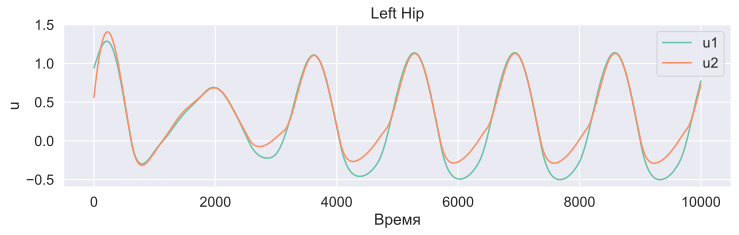

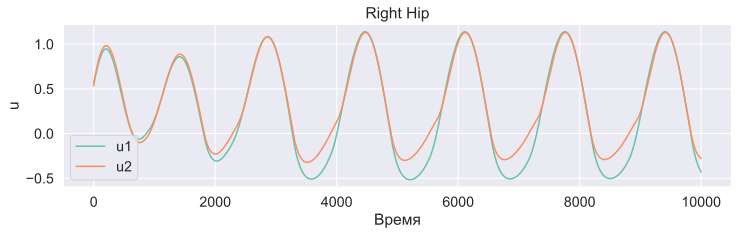

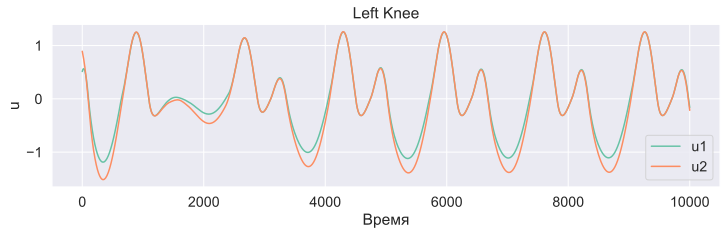

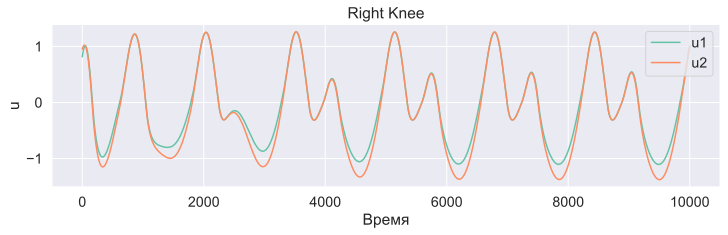

In [91]:
def plot_u(controller, s, j):
    plt.figure(figsize=(12, 3))
    
    plt.title(f'{s.value} {j.value}')
    plt.plot(controller.joints[s][j].u_mon.t / b2.ms, 
             controller.joints[s][j].u_mon.u1[0], label='u1')
    plt.plot(controller.joints[s][j].u_mon.t / b2.ms, 
             controller.joints[s][j].u_mon.u2[0], label='u2')
    
    plt.ylabel('u')
    plt.xlabel('Время')
    plt.legend()
    plt.show()
    
def plot_all(controller):
    plot_u(controller, Side.LEFT, Joint.HIP)
    plot_u(controller, Side.RIGHT, Joint.HIP)
    plot_u(controller, Side.LEFT, Joint.KNEE)
    plot_u(controller, Side.RIGHT, Joint.KNEE)
    
plot_all(c)

In [110]:
env = gym.make('BipedalWalker-v3')
c = Controller(u_init={s: {j: (0.0, 0.0) for j in Joint} for s in Side}, 
               t_step=10 * b2.ms)
observation = env.reset()

for _ in range(100):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]]) * 3
    action = np.clip(action, -1, 1)
#     print(action)
    observation, reward, done, info = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

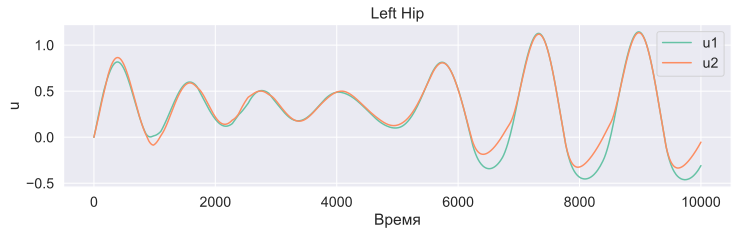

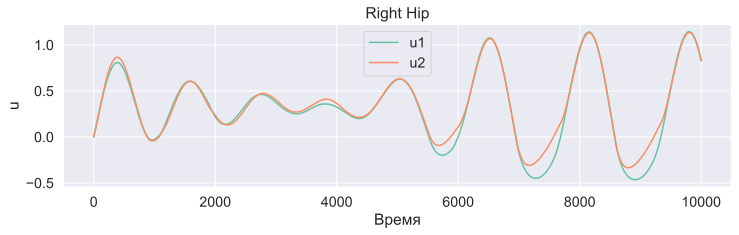

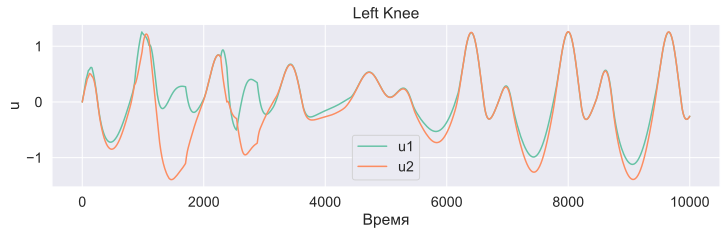

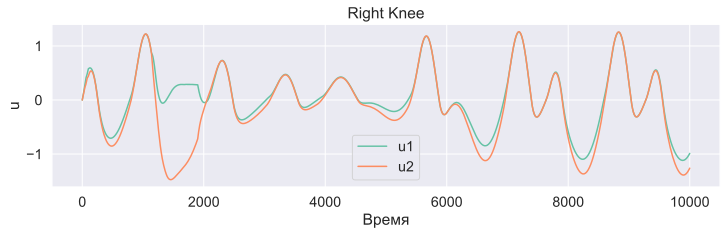

In [89]:
plot_all(c)

In [ ]:
from scipy.optimize import differential_evolution

In [124]:
def make_controller(params):
    return Controller(w=[params[0], 0, 0, params[1], params[2], 0, params[3], 0], 
                      u_init={s: {j: (0.0, 0.0) for j in Joint} for s in Side}, 
                      tau={
                          'u': {Joint.HIP: params[4], Joint.KNEE: params[5]},
                          'v': {Joint.HIP: params[6], Joint.KNEE: params[7]},
                      }, a=params[8:10], u0=params[10], b=params[11], 
                      w_joint=params[12], t_step=10 * b2.ms)


def calc_reward(params, n_iter=100):
    assert(len(params) == 13)
    
    env = gym.make('BipedalWalker-v3')
#     c = Controller(w=params[:8], 
#                    u_init={
#                        Side.LEFT: {Joint.HIP: params[8:10], Joint.KNEE: params[10:12]},
#                        Side.RIGHT: {Joint.HIP: params[12:14], Joint.KNEE: params[14:16]},
#                    }, 
#                    tau={
#                        'u': {Joint.HIP: params[16], Joint.KNEE: params[17]},
#                        'v': {Joint.HIP: params[18], Joint.KNEE: params[19]},
#                    }, a=params[20:22], u0=params[22], b=params[23], 
#                    w_joint=params[24], t_step=20 * b2.ms)

    c = make_controller(params)
    
    observation = env.reset()
    total_reward = 0

    for _ in range(n_iter):
        y = c.step(observation)
        action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                           y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
        action = np.clip(action, -1, 1)
        observation, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break

    env.close()
    
    return -total_reward

In [ ]:
params0 = [-0.607, -0.311, -1.649, -1.934, # w1-w8
           0.285, 0.143, 0.302, 0.151,     # tau
           0.124, 0.770,                   # a
           0.805, 3.078, -2.120]           # u0, b, w

#         w1-w8                         tau
bounds = [(-4, 0) for _ in range(4)] + [(0.025, 1) for _ in range(4)] +\
         [(0.025, 1.5) for _ in range(2)] + [(0, 2), (0, 4), (-4, 0)]
#         a                                   u0      b       w

n_iter = 10
pbar = tqdm(total=n_iter)

def callback(x, convergence):
    print(f'params = {x}; convergence = {convergence}\n')
    pbar.update(1)

res = differential_evolution(calc_reward, bounds, maxiter=n_iter, callback=callback,
                             disp=True, x0=params0)
#                                  updating='deferred', workers=-1)
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= -7.77083
params = [-0.96656725 -0.36099314 -2.23253758 -0.25763973  0.16342266  0.80571435
  0.09895233  0.17019233  0.13135589  0.03499049  0.51483804  3.58979869
 -1.88833481]; convergence = 0.005752738369404362
differential_evolution step 2: f(x)= -7.77083
params = [-0.96656725 -0.36099314 -2.23253758 -0.25763973  0.16342266  0.80571435
  0.09895233  0.17019233  0.13135589  0.03499049  0.51483804  3.58979869
 -1.88833481]; convergence = 0.0040839637584369854
differential_evolution step 3: f(x)= -7.77083
params = [-0.96656725 -0.36099314 -2.23253758 -0.25763973  0.16342266  0.80571435
  0.09895233  0.17019233  0.13135589  0.03499049  0.51483804  3.58979869
 -1.88833481]; convergence = 0.0026032753945955138
differential_evolution step 4: f(x)= -7.86679
params = [-1.01864638 -0.07767022 -1.61812188 -0.75077096  0.7498888   0.98248354
  0.14527428  0.56253532  0.05700838  0.30914629  1.1349054   2.39688049
 -0.98982522]; convergence = 0.0016573962848

In [ ]:
env = gym.make('BipedalWalker-v3')
c = make_controller(res.x)
observation = env.reset()

for _ in range(250):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1)
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

In [ ]:
plot_all(c)

(-0.15, 0.1)

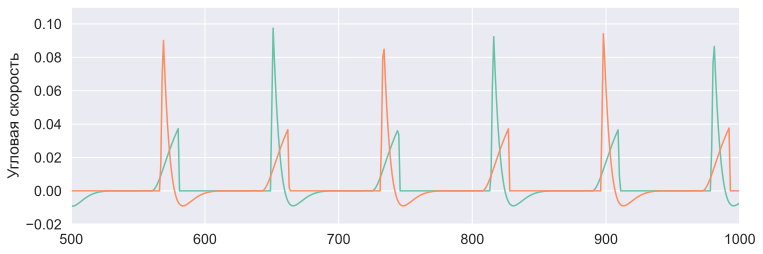

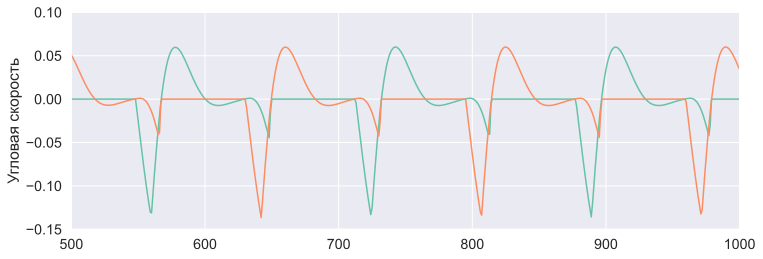

In [227]:
plt.figure(figsize=(12, 4))
plt.ylabel('Угловая скорость')
plt.plot([item[Side.LEFT][Joint.KNEE] for item in y])
plt.plot([item[Side.RIGHT][Joint.KNEE] for item in y])
plt.xlim((500, 1000))
plt.ylim((-0.02, 0.11))

plt.figure(figsize=(12, 4))
plt.ylabel('Угловая скорость')
plt.plot([item[Side.LEFT][Joint.HIP] for item in y])
plt.plot([item[Side.RIGHT][Joint.HIP] for item in y])
plt.xlim((500, 1000))
plt.ylim((-0.15, 0.1))